In [1]:
%matplotlib inline

In [2]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [3]:
# we have two dataframes, a post-level dataframe and a user-level dataframe
posts = pd.DataFrame.from_csv('data/features/liwc.csv')
sent1 = pd.DataFrame.from_csv('data/features/sentiment_all.csv')
read1 = pd.DataFrame.from_csv('data/features/readability1.csv')
read2 = pd.DataFrame.from_csv('data/features/readability2.csv')
times = pd.DataFrame.from_csv('data/features/timing.csv')
words = pd.DataFrame.from_csv('data/features/bow_100.csv')
sents = pd.DataFrame.from_csv('data/features/sentence_features.csv')

posts = posts\
    .merge(sent1[['post_id', 'user_id', 'text_sentiment', 'title_sentiment']], on='post_id')\
    .meitrge(read1[['post_id', 'text_smog', 'text_readability', 'title_readability']], on='post_id')\
    .merge(read2[['post_id', 'title_smog']], on='post_id')\
    .merge(times[['post_id', 'night_post', 'time_since_last_post']], on='post_id')\
    .merge(words, on='post_id')\
    .merge(sents, on='post_id')

In [4]:
subrs = pd.DataFrame.from_csv('data/features/subreddits.csv')

In [5]:
%reset_selective sent1
%reset_selective read1
%reset_selective read2
%reset_selective times
%reset_selective words
%reset_selective sents

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y
Once deleted, variables cannot be recovered. Proceed (y/[n])?  y
Once deleted, variables cannot be recovered. Proceed (y/[n])?  y
Once deleted, variables cannot be recovered. Proceed (y/[n])?  y
Once deleted, variables cannot be recovered. Proceed (y/[n])?  y
Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [6]:
train_classes = pd.DataFrame.from_csv('data/classes/train_classes.txt')
dev_classes = pd.DataFrame.from_csv('data/classes/dev_classes.txt')
test_classes = pd.DataFrame.from_csv('data/classes/test_classes.txt')

In [7]:
training = posts.merge(train_classes, on='post_id')
dev = posts.merge(dev_classes, on='post_id')
testing = posts.merge(test_classes, on='post_id')

%reset_selective posts

Once deleted, variables cannot be recovered. Proceed (y/[n])?  n
Nothing done.


In [8]:
sd_features = [
    'text_sentiment', 'title_sentiment', 'text_smog', 'text_readability',
    'title_readability', 'title_smog', 'night_post', 'time_since_last_post', 'user_id'
]

In [13]:
def process_df(df):
    df_grouped = df.drop('class', 1).drop('post_id', 1).groupby('user_id')
    df_grouped_sd = df[sd_features].groupby('user_id').aggregate(np.std).reset_index()
    df_grouped_cnt = df[['user_id', 'post_id']].groupby('user_id').agg({ 'post_id': pd.Series.nunique })
    df_grouped_cnt = df_grouped_cnt.reset_index()

    return df_grouped.aggregate(np.sum).reset_index()\
        .merge(df_grouped_sd, on='user_id')\
        .merge(df_grouped_cnt, on='user_id')

In [16]:
training = process_df(training)
dev = process_df(dev)
testing = process_df(testing)

In [18]:
X_train = training.merge(subrs, on='user_id').drop('user_id', 1).as_matrix()
y_train = (training['user_id'] > 0).as_matrix()

X_dev = dev.merge(subrs, on='user_id').drop('user_id', 1).as_matrix()
y_dev = (dev['user_id'] > 0).as_matrix()

X_test = testing.merge(subrs, on='user_id').drop('user_id', 1).as_matrix()
y_test = (testing['user_id'] > 0).as_matrix()

%reset_selective testing
%reset_selective dev
%reset_selective training

Once deleted, variables cannot be recovered. Proceed (y/[n])?  n
Nothing done.
Once deleted, variables cannot be recovered. Proceed (y/[n])?  n
Nothing done.
Once deleted, variables cannot be recovered. Proceed (y/[n])?  n
Nothing done.


In [19]:
X_train[np.isnan(X_train)] = 10000.
X_dev[np.isnan(X_dev)] = 10000.
X_test[np.isnan(X_test)] = 10000.

# Aggregating our Data

In [38]:
clf = RandomForestClassifier(
    n_estimators=42, 
    max_depth=14,
    min_samples_leaf=13,
    n_jobs=6, 
    random_state=1, 
    min_impurity_split=2e-2,
    warm_start=True,
    max_features=150
)

clf.fit(X_train, y_train)

# 40, 15, 15, 1, 1e-2, True

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features=150, max_leaf_nodes=None,
            min_impurity_split=0.02, min_samples_leaf=13,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=42, n_jobs=6, oob_score=False, random_state=1,
            verbose=0, warm_start=True)

Accuracy: 0.790571169538
AUC: 0.880546420149
F1 Score: 0.786506469501


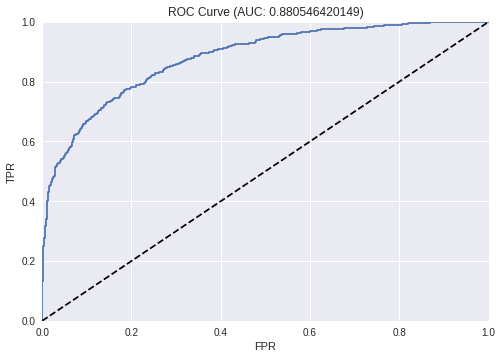

In [40]:
X_cur, y_cur = X_test, y_test

labels = clf.predict_proba(X_cur)

print 'Accuracy:', accuracy_score(y_cur, np.argmax(labels, axis=1))

fpr, tpr, thresholds = roc_curve(y_cur, labels[:, 1])

plt.plot(fpr, tpr)
plt.title('ROC Curve (AUC: {})'.format(roc_auc_score(y_cur, labels[:, 1])))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot([0, 1], [0, 1], 'k--')

print 'AUC:', roc_auc_score(y_cur, labels[:, 1])
print 'F1 Score:', f1_score(y_cur, np.argmax(labels, axis=1))

plt.savefig('100_test_ROC_Curve.png')